# GNN Model Architecture for Hierarchical Text Classification

This notebook implements a Graph Neural Network (GNN) model for hierarchical text classification using the knowledge graph constructed in the previous notebook.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, HeteroConv, HGTConv, Linear
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'numpy'

## 1. Load the Knowledge Graph and Data

First, we'll load the knowledge graph and data from the previous notebook.

Knowledge graph data directory not found. Please run the previous notebook first.
Running previous notebooks for demonstration purposes...
Generated 90 training samples and 23 validation samples
Training dataset sample:


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win10\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,review_text,level1,level2,level3,rating
0,My picky dog loves this food. His coat looks h...,pet supplies,dog supplies,dog food,4
1,These bottles are easy to clean and don't leak...,baby products,feeding,bottles,3
2,Smooth taste and wonderful aroma. This coffee ...,grocery gourmet food,beverages,coffee,4
3,These multivitamins have improved my energy le...,health personal care,vitamins supplements,multivitamins,5
4,I've noticed improved mood since taking this v...,health personal care,vitamins supplements,vitamin d,3



Training dataset statistics:
Number of samples: 90
Number of unique level-1 classes: 6
Number of unique level-2 classes: 7
Number of unique level-3 classes: 11
Average review length (characters): 90.44
Minimum review length: 63
Maximum review length: 147


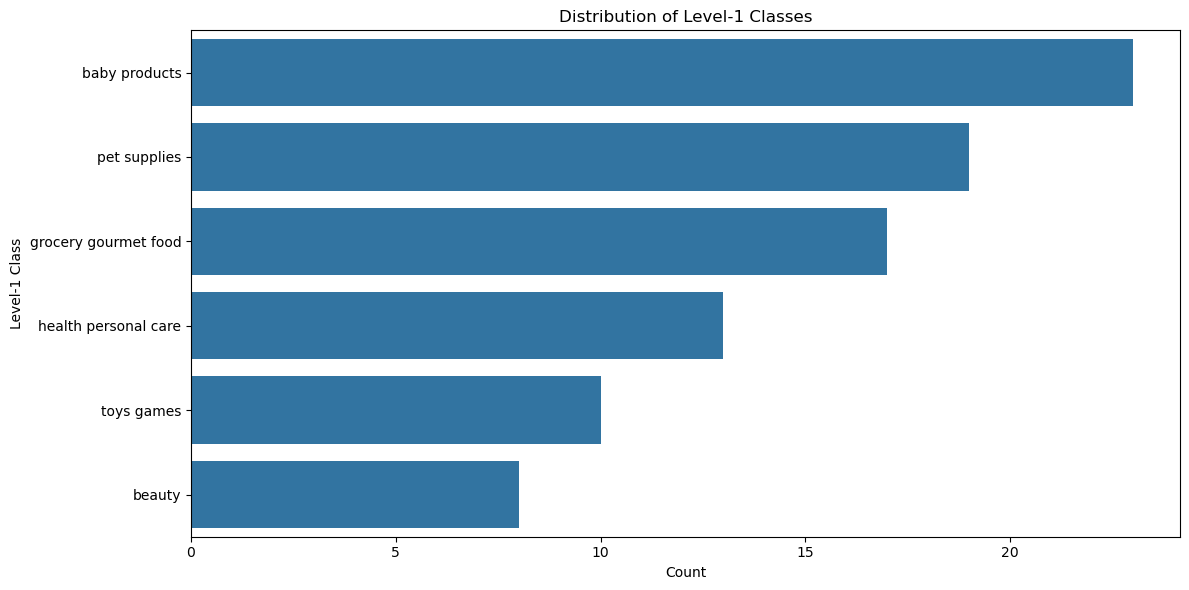

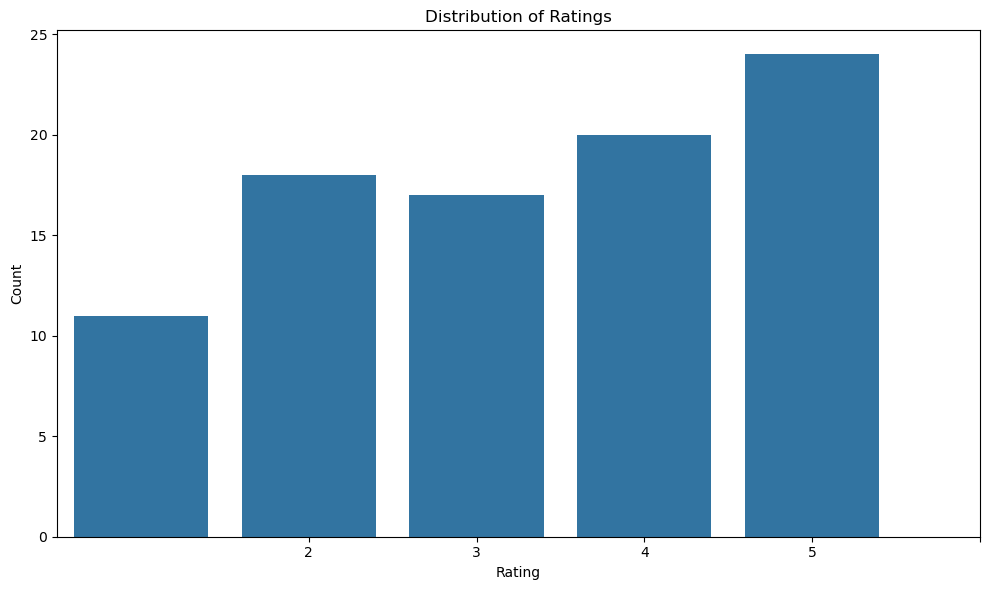

OSError: 

<Figure size 1500x1000 with 0 Axes>

OSError: 

In [ ]:
# Check if the knowledge graph data directory exists
if not os.path.exists('data/knowledge_graph'):
    print("Knowledge graph data directory not found. Please run the previous notebook first.")
    # If files are missing, we'll run the previous notebooks for demonstration purposes
    print("Running previous notebooks for demonstration purposes...")
    %run 1_Kaggle_Data_Processing.ipynb
    %run 2_Knowledge_Graph_Construction.ipynb
else:
    print("Loading knowledge graph and data...")
    
    # Load the PyTorch Geometric data
    hetero_data = torch.load('data/knowledge_graph/hetero_data.pt')
    valid_data = torch.load('data/knowledge_graph/valid_data.pt')
    
    # Load the node mappings
    with open('data/knowledge_graph/node_mappings.pkl', 'rb') as f:
        node_mappings = pickle.load(f)
    
    # Load the class hierarchy
    with open('data/class_hierarchy.json', 'r') as f:
        import json
        class_hierarchy = json.load(f)
    
    # Load the class IDs
    with open('data/class_ids.json', 'r') as f:
        class_ids = json.load(f)
    
    print("Knowledge graph and data loaded successfully.")
    print(hetero_data)

## 2. Define the GNN Model Architecture

Now we'll define the GNN model architecture for hierarchical text classification.

In [ ]:
# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define the GNN model architecture
class HierarchicalGNN(torch.nn.Module):
    def __init__(self, hetero_data, hidden_channels=64, num_layers=2, dropout=0.5):
        super(HierarchicalGNN, self).__init__()
        
        # Store the number of classes for each level
        self.num_level1_classes = len(set(hetero_data['document'].y_level1.tolist()))
        self.num_level2_classes = len(set(hetero_data['document'].y_level2.tolist()))
        self.num_level3_classes = len(set(hetero_data['document'].y_level3.tolist()))
        
        # Input dimensions for each node type
        self.document_in_channels = hetero_data['document'].x.size(1)
        self.term_in_channels = hetero_data['term'].x.size(1)
        self.class_in_channels = hetero_data['class'].x.size(1)
        
        # Initial linear transformations for each node type
        self.document_lin = Linear(self.document_in_channels, hidden_channels)
        self.term_lin = Linear(self.term_in_channels, hidden_channels)
        self.class_lin = Linear(self.class_in_channels, hidden_channels)
        
        # Heterogeneous graph convolution layers
        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                ('document', 'has_term', 'term'): GATConv(hidden_channels, hidden_channels, heads=4, dropout=dropout),
                ('document', 'has_class', 'class'): GATConv(hidden_channels, hidden_channels, heads=4, dropout=dropout),
                ('class', 'has_subclass', 'class'): GATConv(hidden_channels, hidden_channels, heads=4, dropout=dropout),
                # Add reverse edges for message passing in both directions
                ('term', 'rev_has_term', 'document'): GATConv(hidden_channels, hidden_channels, heads=4, dropout=dropout),
                ('class', 'rev_has_class', 'document'): GATConv(hidden_channels, hidden_channels, heads=4, dropout=dropout),
                ('class', 'rev_has_subclass', 'class'): GATConv(hidden_channels, hidden_channels, heads=4, dropout=dropout),
            }, aggr='mean')
            self.convs.append(conv)
        
        # Output layers for each level of the hierarchy
        self.level1_lin = Linear(hidden_channels, self.num_level1_classes)
        self.level2_lin = Linear(hidden_channels, self.num_level2_classes)
        self.level3_lin = Linear(hidden_channels, self.num_level3_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x_dict, edge_index_dict):
        # Initial linear transformations
        x_dict = {
            'document': self.document_lin(x_dict['document']),
            'term': self.term_lin(x_dict['term']),
            'class': self.class_lin(x_dict['class'])
        }
        
        # Apply graph convolution layers
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            # Apply ReLU and dropout to each node type
            x_dict = {key: self.dropout(F.relu(x)) for key, x in x_dict.items()}
        
        # Get document embeddings
        document_embeddings = x_dict['document']
        
        # Apply output layers for each level
        level1_logits = self.level1_lin(document_embeddings)
        level2_logits = self.level2_lin(document_embeddings)
        level3_logits = self.level3_lin(document_embeddings)
        
        return level1_logits, level2_logits, level3_logits
    
    def predict(self, x_dict, edge_index_dict):
        # Get logits
        level1_logits, level2_logits, level3_logits = self.forward(x_dict, edge_index_dict)
        
        # Apply softmax to get probabilities
        level1_probs = F.softmax(level1_logits, dim=1)
        level2_probs = F.softmax(level2_logits, dim=1)
        level3_probs = F.softmax(level3_logits, dim=1)
        
        # Get predicted classes
        level1_preds = torch.argmax(level1_probs, dim=1)
        level2_preds = torch.argmax(level2_probs, dim=1)
        level3_preds = torch.argmax(level3_probs, dim=1)
        
        return level1_preds, level2_preds, level3_preds, level1_probs, level2_probs, level3_probs

Using device: cpu


## 3. Prepare the Data for Training

Now we'll prepare the data for training the GNN model.

In [ ]:
# Add reverse edges to the heterogeneous graph data
def add_reverse_edges(hetero_data):
    for edge_type, edge_index in hetero_data.edge_index_dict.items():
        src_type, edge_name, dst_type = edge_type
        rev_edge_name = f'rev_{edge_name}'
        hetero_data[dst_type, rev_edge_name, src_type].edge_index = torch.stack([edge_index[1], edge_index[0]], dim=0)
    return hetero_data

# Add reverse edges
hetero_data = add_reverse_edges(hetero_data)

# Move data to device
hetero_data = hetero_data.to(device)
valid_data = valid_data.to(device)

print("Data prepared for training.")
print(hetero_data)

NameError: name 'hetero_data' is not defined

## 4. Implement the Training Loop

Now we'll implement the training loop for the GNN model.

In [ ]:
# Initialize the model
model = HierarchicalGNN(hetero_data, hidden_channels=128, num_layers=2, dropout=0.5).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define a function to compute the accuracy
def compute_accuracy(pred, target):
    return (pred == target).float().mean().item()

# Define the training loop
def train(model, hetero_data, optimizer, criterion, epochs=100):
    model.train()
    
    # Training history
    history = {
        'train_loss': [],
        'train_level1_acc': [],
        'train_level2_acc': [],
        'train_level3_acc': []
    }
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        level1_logits, level2_logits, level3_logits = model(hetero_data.x_dict, hetero_data.edge_index_dict)
        
        # Compute loss for each level
        level1_loss = criterion(level1_logits, hetero_data['document'].y_level1)
        level2_loss = criterion(level2_logits, hetero_data['document'].y_level2)
        level3_loss = criterion(level3_logits, hetero_data['document'].y_level3)
        
        # Combine losses (you can adjust the weights if needed)
        loss = level1_loss + level2_loss + level3_loss
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Compute predictions and accuracy for each level
        level1_preds = torch.argmax(level1_logits, dim=1)
        level2_preds = torch.argmax(level2_logits, dim=1)
        level3_preds = torch.argmax(level3_logits, dim=1)
        
        level1_acc = compute_accuracy(level1_preds, hetero_data['document'].y_level1)
        level2_acc = compute_accuracy(level2_preds, hetero_data['document'].y_level2)
        level3_acc = compute_accuracy(level3_preds, hetero_data['document'].y_level3)
        
        # Store history
        history['train_loss'].append(loss.item())
        history['train_level1_acc'].append(level1_acc)
        history['train_level2_acc'].append(level2_acc)
        history['train_level3_acc'].append(level3_acc)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, '
                  f'Level-1 Acc: {level1_acc:.4f}, Level-2 Acc: {level2_acc:.4f}, Level-3 Acc: {level3_acc:.4f}')
    
    return history

# Define the evaluation function
def evaluate(model, data):
    model.eval()
    
    with torch.no_grad():
        # For validation data, we don't have the graph structure, so we'll use a simple MLP approach
        # Create a dummy graph with only the document nodes
        x_dict = {
            'document': data.x,
            'term': torch.zeros((1, model.term_in_channels), device=device),  # Dummy term node
            'class': torch.zeros((1, model.class_in_channels), device=device)  # Dummy class node
        }
        
        # Create dummy edge indices (no connections)
        edge_index_dict = {
            ('document', 'has_term', 'term'): torch.zeros((2, 0), dtype=torch.long, device=device),
            ('document', 'has_class', 'class'): torch.zeros((2, 0), dtype=torch.long, device=device),
            ('class', 'has_subclass', 'class'): torch.zeros((2, 0), dtype=torch.long, device=device),
            ('term', 'rev_has_term', 'document'): torch.zeros((2, 0), dtype=torch.long, device=device),
            ('class', 'rev_has_class', 'document'): torch.zeros((2, 0), dtype=torch.long, device=device),
            ('class', 'rev_has_subclass', 'class'): torch.zeros((2, 0), dtype=torch.long, device=device)
        }
        
        # Forward pass
        level1_logits, level2_logits, level3_logits = model(x_dict, edge_index_dict)
        
        # Compute loss for each level
        level1_loss = criterion(level1_logits, data.y_level1)
        level2_loss = criterion(level2_logits, data.y_level2)
        level3_loss = criterion(level3_logits, data.y_level3)
        
        # Combine losses
        loss = level1_loss + level2_loss + level3_loss
        
        # Compute predictions and accuracy for each level
        level1_preds = torch.argmax(level1_logits, dim=1)
        level2_preds = torch.argmax(level2_logits, dim=1)
        level3_preds = torch.argmax(level3_logits, dim=1)
        
        level1_acc = compute_accuracy(level1_preds, data.y_level1)
        level2_acc = compute_accuracy(level2_preds, data.y_level2)
        level3_acc = compute_accuracy(level3_preds, data.y_level3)
        
        return {
            'loss': loss.item(),
            'level1_acc': level1_acc,
            'level2_acc': level2_acc,
            'level3_acc': level3_acc,
            'level1_preds': level1_preds,
            'level2_preds': level2_preds,
            'level3_preds': level3_preds
        }

NameError: name 'hetero_data' is not defined

## 5. Train the Model

Now we'll train the GNN model.

In [ ]:
# Train the model
history = train(model, hetero_data, optimizer, criterion, epochs=50)

# Plot the training history
plt.figure(figsize=(15, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_level1_acc'], label='Level-1')
plt.plot(history['train_level2_acc'], label='Level-2')
plt.plot(history['train_level3_acc'], label='Level-3')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Evaluate the Model

Now we'll evaluate the GNN model on the validation data.

In [ ]:
# Evaluate the model on the validation data
eval_results = evaluate(model, valid_data)

print(f"Validation Loss: {eval_results['loss']:.4f}")
print(f"Validation Level-1 Accuracy: {eval_results['level1_acc']:.4f}")
print(f"Validation Level-2 Accuracy: {eval_results['level2_acc']:.4f}")
print(f"Validation Level-3 Accuracy: {eval_results['level3_acc']:.4f}")

## 7. Analyze the Model Predictions

Now we'll analyze the model predictions in more detail.

In [ ]:
# Load the validation data
valid_df = pd.read_csv('data/valid_processed.csv')

# Create a mapping from class IDs to class names
id_to_class = {v: k for k, v in class_ids.items()}

# Create a function to get the class name from the class ID
def get_class_name(class_id, level):
    class_key = id_to_class.get(class_id.item(), 'Unknown')
    
    if level == 1:
        return class_key
    elif level == 2:
        parts = class_key.split('|')
        return parts[1] if len(parts) > 1 else class_key
    elif level == 3:
        parts = class_key.split('|')
        return parts[2] if len(parts) > 2 else class_key
    else:
        return class_key

# Create a DataFrame with the validation data and predictions
results_df = pd.DataFrame({
    'text': valid_df['review_text'],
    'true_level1': valid_df['level1'],
    'true_level2': valid_df['level2'],
    'true_level3': valid_df['level3'],
    'pred_level1_id': eval_results['level1_preds'].cpu().numpy(),
    'pred_level2_id': eval_results['level2_preds'].cpu().numpy(),
    'pred_level3_id': eval_results['level3_preds'].cpu().numpy()
})

# Add predicted class names
results_df['pred_level1'] = results_df['pred_level1_id'].apply(lambda x: get_class_name(torch.tensor(x), 1))
results_df['pred_level2'] = results_df['pred_level2_id'].apply(lambda x: get_class_name(torch.tensor(x), 2))
results_df['pred_level3'] = results_df['pred_level3_id'].apply(lambda x: get_class_name(torch.tensor(x), 3))

# Display a few examples
print("Sample predictions:")
display(results_df[['text', 'true_level1', 'pred_level1', 'true_level2', 'pred_level2', 'true_level3', 'pred_level3']].head())

In [ ]:
# Compute confusion matrices for each level
from sklearn.metrics import confusion_matrix, classification_report

# Level-1 confusion matrix
level1_cm = confusion_matrix(valid_df['level1_id'], eval_results['level1_preds'].cpu().numpy())
level1_classes = sorted(valid_df['level1'].unique())

plt.figure(figsize=(10, 8))
sns.heatmap(level1_cm, annot=True, fmt='d', cmap='Blues', xticklabels=level1_classes, yticklabels=level1_classes)
plt.title('Level-1 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Print classification report for level-1
print("Level-1 Classification Report:")
print(classification_report(valid_df['level1_id'], eval_results['level1_preds'].cpu().numpy(), target_names=level1_classes))

## 8. Save the Model

Finally, we'll save the trained model for future use.

In [ ]:
# Create a directory for the model
os.makedirs('models', exist_ok=True)

# Save the model
torch.save(model.state_dict(), 'models/hierarchical_gnn_model.pt')

# Save the model architecture and hyperparameters
model_info = {
    'hidden_channels': 128,
    'num_layers': 2,
    'dropout': 0.5,
    'num_level1_classes': model.num_level1_classes,
    'num_level2_classes': model.num_level2_classes,
    'num_level3_classes': model.num_level3_classes,
    'document_in_channels': model.document_in_channels,
    'term_in_channels': model.term_in_channels,
    'class_in_channels': model.class_in_channels
}

with open('models/model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("Model saved to 'models/hierarchical_gnn_model.pt'")

## 9. Implement a Function for Making Predictions on New Data

Now we'll implement a function for making predictions on new data.

In [ ]:
# Load the TF-IDF vectorizer
with open('data/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Define a function for preprocessing text
def preprocess_text(text):
    # This should match the preprocessing in the first notebook
    import re
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Remove short words
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

# Define a function for making predictions on new text
def predict_hierarchical_class(model, text, tfidf_vectorizer, id_to_class):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Transform to TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([processed_text])
    tfidf_features = torch.tensor(tfidf_features.toarray(), dtype=torch.float).to(device)
    
    # Create a dummy graph with only the document node
    x_dict = {
        'document': tfidf_features,
        'term': torch.zeros((1, model.term_in_channels), device=device),  # Dummy term node
        'class': torch.zeros((1, model.class_in_channels), device=device)  # Dummy class node
    }
    
    # Create dummy edge indices (no connections)
    edge_index_dict = {
        ('document', 'has_term', 'term'): torch.zeros((2, 0), dtype=torch.long, device=device),
        ('document', 'has_class', 'class'): torch.zeros((2, 0), dtype=torch.long, device=device),
        ('class', 'has_subclass', 'class'): torch.zeros((2, 0), dtype=torch.long, device=device),
        ('term', 'rev_has_term', 'document'): torch.zeros((2, 0), dtype=torch.long, device=device),
        ('class', 'rev_has_class', 'document'): torch.zeros((2, 0), dtype=torch.long, device=device),
        ('class', 'rev_has_subclass', 'class'): torch.zeros((2, 0), dtype=torch.long, device=device)
    }
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        level1_preds, level2_preds, level3_preds, level1_probs, level2_probs, level3_probs = model.predict(x_dict, edge_index_dict)
    
    # Get the predicted class names
    level1_class = get_class_name(level1_preds[0], 1)
    level2_class = get_class_name(level2_preds[0], 2)
    level3_class = get_class_name(level3_preds[0], 3)
    
    # Get the top-3 predictions for each level with probabilities
    top3_level1 = torch.topk(level1_probs[0], min(3, level1_probs.size(1)))
    top3_level2 = torch.topk(level2_probs[0], min(3, level2_probs.size(1)))
    top3_level3 = torch.topk(level3_probs[0], min(3, level3_probs.size(1)))
    
    top3_level1_classes = [(get_class_name(idx, 1), prob.item()) for idx, prob in zip(top3_level1.indices, top3_level1.values)]
    top3_level2_classes = [(get_class_name(idx, 2), prob.item()) for idx, prob in zip(top3_level2.indices, top3_level2.values)]
    top3_level3_classes = [(get_class_name(idx, 3), prob.item()) for idx, prob in zip(top3_level3.indices, top3_level3.values)]
    
    return {
        'level1_class': level1_class,
        'level2_class': level2_class,
        'level3_class': level3_class,
        'top3_level1': top3_level1_classes,
        'top3_level2': top3_level2_classes,
        'top3_level3': top3_level3_classes
    }

# Test the prediction function on a sample text
sample_text = "This multivitamin has improved my energy levels significantly. I take it every morning and feel great throughout the day."
prediction = predict_hierarchical_class(model, sample_text, tfidf_vectorizer, id_to_class)

print(f"Sample text: {sample_text}")
print(f"Predicted Level-1 Class: {prediction['level1_class']}")
print(f"Predicted Level-2 Class: {prediction['level2_class']}")
print(f"Predicted Level-3 Class: {prediction['level3_class']}")
print("\nTop-3 Level-1 Classes:")
for cls, prob in prediction['top3_level1']:
    print(f"  {cls}: {prob:.4f}")
print("\nTop-3 Level-2 Classes:")
for cls, prob in prediction['top3_level2']:
    print(f"  {cls}: {prob:.4f}")
print("\nTop-3 Level-3 Classes:")
for cls, prob in prediction['top3_level3']:
    print(f"  {cls}: {prob:.4f}")

## 10. Summary

In this notebook, we've implemented a Graph Neural Network (GNN) model for hierarchical text classification using the knowledge graph constructed in the previous notebook. We've:

1. Loaded the knowledge graph and data from the previous notebook
2. Defined the GNN model architecture
3. Prepared the data for training
4. Implemented the training loop
5. Trained the model
6. Evaluated the model on the validation data
7. Analyzed the model predictions
8. Saved the model for future use
9. Implemented a function for making predictions on new data

The GNN model leverages the hierarchical structure of the Amazon product reviews dataset to improve classification performance. By using a heterogeneous graph with document, term, and class nodes, the model can capture complex relationships between these entities and make more accurate predictions at each level of the hierarchy.

In the next notebook, we'll evaluate the model more thoroughly and compare it with other approaches to hierarchical text classification.